#Autoencoder

In thie problem, we train an autoencoder using the mnist data set.

## Load the data

First, we load the mnist data and normalize the images. Note we use the last 5000 samples in the x_train_full for validation.

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
print(x_train.shape, x_valid.shape, x_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


Next, we reshape the images to (28, 28, 1).

In [ ]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_valid = np.reshape(x_valid, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

We print out the first 50 training images.

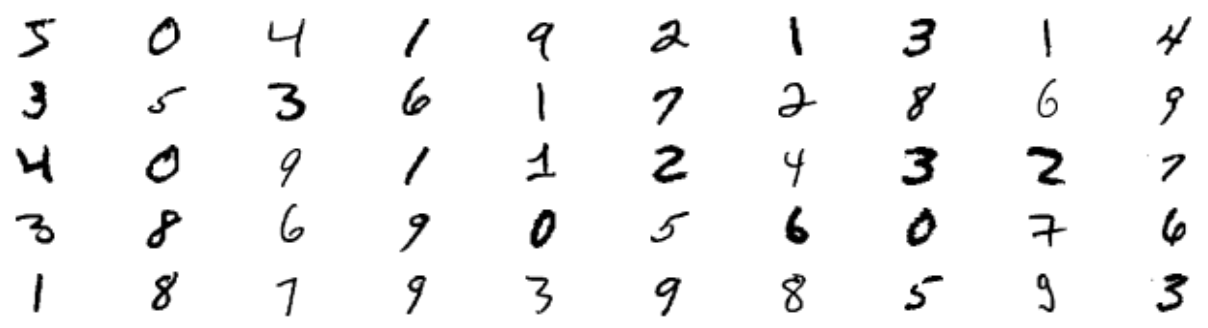

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
for index, digit in enumerate(x_train[:50]):
    plt.subplot(50 // 10, 10, index + 1)
    plt.imshow(digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

# Build  an autoencoder

First import some modules needed for this part of the code.

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

We build a autoencoder using Conv2D layers.

First, we build the encoder.

In [ ]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 8
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [16, 32]

In [ ]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Dropout(0.5)(x)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [ ]:
# shape info needed to build decoder model

shape = K.int_shape(x)

In [ ]:
shape

(None, 7, 7, 32)

In [ ]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 latent_vector (Dense)       (None, 8)                 12552     
                                                                 
Total params: 17352 (67.78 KB)
Trainable params: 17352 (67.

Now we build the decoder.

In [ ]:
# build the decoder model
latent_inputs = Input(shape=(,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [ ]:
for filters in layer_filters[::-1]:
    x = (filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [ ]:
outputs = (filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 1568)              14112     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        4624      
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         145 

Combine the encoder and the decoder as the autocoder.

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 8)                 17352     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28129     
                                                                 
Total params: 45481 (177.66 KB)
Trainable params: 45481 (177.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the autoencoder.

In [ ]:
autoencoder.compile(loss='', optimizer='adam')

Train the autoencoder. Use restore_best_weights to restore the best weights.

In [ ]:
# train the autoencoder
history = autoencoder.fit(x_train,
                ,
                validation_data=(x_valid, x_valid),
                epochs=100,
                batch_size=batch_size, callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/100
1719/1719 [==============================] - 20s 5ms/step - loss: 0.0380 - val_loss: 0.0486
Epoch 2/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0238 - val_loss: 0.0511
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0224 - val_loss: 0.0502
Epoch 4/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0217 - val_loss: 0.0526
Epoch 5/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0212 - val_loss: 0.0451
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0208 - val_loss: 0.0478
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0205 - val_loss: 0.0447
Epoch 8/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0203 - val_loss: 0.0444
Epoch 9/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0201 - val_loss: 0.0443
Epoch 10/100
1719/1719 [==============================] - 8s 4ms/step - 

Plot training and validation losses during the traing.

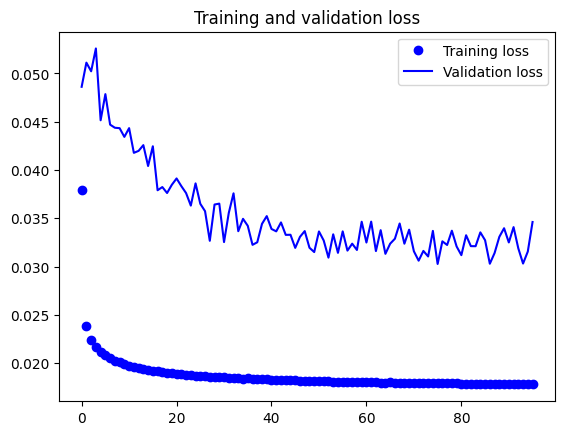

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Save the models

In [ ]:
autoencoder.save("autoencoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
encoder.save("encoder.h5")

In [ ]:
encoder.save("decoder.h5")